<a href="https://colab.research.google.com/github/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/03_Batch_Prediction_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Batch Prediction Pipeline

The main purpose of this notebook is to build KFP pipeline doing the following steps
1. Create an batch request input file (file list format) based on the files uploaded to a GCS bucket
2. Run Batch Prediction on the trained model obtained from [02_TFX_Training_Pipeline.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/02_TFX_Training_Pipeline.ipynb)
3. Measure the batch prediction model performance in terms of accuracy
4. If model performance < threshold
  - Copy the testing images to the original(previous) dataset
  - Trigger the TFX training pipeline with original data + newly added data

The functional test for batch prediction is shown in a separate notebook, [98_Batch_Prediction_Test.ipynb](https://github.com/deep-diver/Continuous-Adaptation-for-Machine-Learning-System-to-Data-Changes/blob/main/notebooks/98_Batch_Prediction_Test.ipynb).

## Setup

In [ ]:
!pip install fastdot
!pip install -q --upgrade google-cloud-aiplatform
!pip install -q --upgrade google-cloud-storage

In [ ]:
!gcloud init

In [ ]:
from google.colab import auth
auth.authenticate_user()

## Custom TFX Components

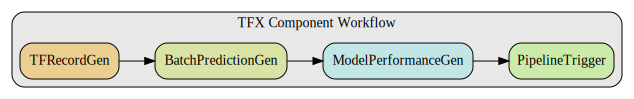

In [11]:
#@title
from fastdot.core import *

tfx_components = ['TFRecordGen', 'BatchPredictionGen', 'ModelPerformanceGen', 'PipelineTrigger']
block = 'TFX Component Workflow'

g = graph_items(seq_cluster(tfx_components, block))
g

### **TFRecordGen Component [OPTIONAL]**

- If we assume dataset is already prepared in TFRecord format, we don't need `TFRecordPrep` component. 
- If we assume dataset is not packed as TFRecord format, `TFRecordPrep` will prepare the dataset in TFRecord format.

**Spec**
- input
  - GCS path where the raw files are
  - GCS path where the TFRecord file will be 
- output
  - GCS path where the TFRecord file is

### BatchPredictionGen Component
- Behaviour of `BatchPredictionGen` is similar to TFX standard component `BulkInferrer`.
- The only difference is we don't need `Model` artifact from `Trainer` but just `model ID` that can be found in `Vertex AI Model` registry.
- Predicted results will be fed into the `PerformanceEvaluator` component.

**Spec**
- input
  - GCS path where the TFRecord file is
  - model id from Vertex AI Model
- output
  - predictions

### **PerformanceEvaluator Component**
- Calculate any performance metrics 
- Outputs if the model performance is above or below the given threshold

**Spec**
- input
  - predictions
  - threshold
- output
  - `True` or `False` by the threshold

### PipelineTrigger Component
- Trigger the training pipeline based on the `True` or `False` value by the threshold

**Spec**
- input
  - `True` or `False` by threshold
  - pipeline name to be triggered
  - GCS path where the pipeline spec is 
  - GCP project ID
  - GCP region
- output
  - None